In [1]:
import numpy as np
import matplotlib.pyplot as plt

### Parameters

In [2]:
MASSES = [1, 1, 1, 1, 1]              # Masses of each particle
PARTICLES = len(MASSES)               # Number of particles

T = 40                                # Number of steps taken in the orbit

FOURIER_TERMS = 5                     # Number of Fourier coeficients 

LEARNING_STEPS = 500                  # Number of training steps
LEARNING_RATE = 1e-3                  # Learning rate

The action is a function of W = ( A_c, A_s, B_c, B_s, phi )

In [3]:
def position (W, i, t):
    
    a, b, c, d, phi = W
    
    pos_x, pos_y = 0, 0
    
    for k in range(FOURIER_TERMS + 1):
        
        pos_x += a[k] * np.cos( k * ( t + phi[i] ) ) + b[k] * np.sin( k * ( t + phi[i] ) )
        pos_y += c[k] * np.cos( k * ( t + phi[i] ) ) + d[k] * np.sin( k * ( t + phi[i] ) )
        
    return np.array([pos_x, pos_y])

def speed(W, i, t):
    
    a, b, c, d, phi = W
    
    vel_x, vel_y = 0, 0
    
    for k in range(FOURIER_TERMS + 1):
        
        vel_x += k * ( - a[k] * np.sin( k * ( t + phi[i] ) ) + b[k] * np.cos( k * ( t + phi[i] ) ) )
        vel_y += k * ( - c[k] * np.sin( k * ( t + phi[i] ) ) + d[k] * np.cos( k * ( t + phi[i] ) ) )
        
    return np.array([vel_x, vel_y])
        
def action (W):
    
    S = 0
    
    for t in range(T):
        
        time = 2 * t * np.pi / T
        
        for i in range(PARTICLES):
            
            S += ( MASSES[i] / 2 ) * np.linalg.norm( speed(W, i, time) ) ** 2
            
            for j in range(i + 1, PARTICLES):
                
                S += MASSES[i] * MASSES[j] / ( np.linalg.norm( position(W, i, time) 
                                                             - position(W, j, time) ) )
        
    return S * ( 2 * np.pi / T )

We compute the gradient of the action respect to each one of the parameters in W

In [4]:
def grad (W, actualize_bias = False):
    
    a, b, c, d, phi = W

    grad_a = np.zeros( ( FOURIER_TERMS + 1 ) )
    grad_b = np.zeros( ( FOURIER_TERMS + 1 ) )
    grad_c = np.zeros( ( FOURIER_TERMS + 1 ) )
    grad_d = np.zeros( ( FOURIER_TERMS + 1 ) )
    
    for t in range(T):
        
        time = 2 * t * np.pi / T
        
        for i in range( PARTICLES ):
            
            pos_i = position(W, i, time )
            vel_i = speed(W, i, time )
            
            for k in range( FOURIER_TERMS + 1 ):
                
                t_ki = k * ( time + phi[i] )

                if k == 0 and not actualize_bias:    
                    continue
                                
                grad_a [k] += - MASSES[i] * vel_i[0] * np.sin( t_ki ) * k
                grad_b [k] += + MASSES[i] * vel_i[0] * np.cos( t_ki ) * k
                grad_c [k] += - MASSES[i] * vel_i[1] * np.sin( t_ki ) * k
                grad_d [k] += + MASSES[i] * vel_i[1] * np.cos( t_ki ) * k

                for j in range( i + 1, PARTICLES ):
                    
                    t_kj = k * ( time + phi[j] )
                    
                    pos_j = position(W, j, time)
                    vel_j = speed(W, j, time)
                    
                    grad_a [k] += - MASSES[i] * MASSES[j]   \
                                        / ( np.linalg.norm( pos_i - pos_j ) ** 3 ) \
                                        * ( pos_i[0] - pos_j[0] ) \
                                        * ( np.cos( t_ki ) - np.cos( t_kj ) )
                    grad_b [k] += - MASSES[i] * MASSES[j]   \
                                        / ( np.linalg.norm( pos_i - pos_j ) ** 3 ) \
                                        * ( pos_i[0] - pos_j[0] ) \
                                        * ( np.sin( t_ki ) - np.sin( t_kj ) )
                    grad_c [k] += - MASSES[i] * MASSES[j]   \
                                        / ( np.linalg.norm( pos_i - pos_j ) ** 3 ) \
                                        * ( pos_i[1] - pos_j[1] ) \
                                        * ( np.cos( t_ki ) - np.cos( t_kj ) )
                    grad_d [k] += - MASSES[i] * MASSES[j]   \
                                        / ( np.linalg.norm( pos_i - pos_j ) ** 3 ) \
                                        * ( pos_i[1] - pos_j[1] ) \
                                        * ( np.sin( t_ki ) - np.sin( t_kj ) )
                                
                    
    grad_phi = np.zeros( ( PARTICLES ) )

    for t in range(T):
        
        time = 2 * t * np.pi / T
        
        for i in range( PARTICLES ):
        
            sum1, sum2 = 0, 0 
            
            pos_i = position(W, i, time )
            vel_i = speed(W, i, time )

            for k in range( FOURIER_TERMS + 1 ):
                
                t_ki = k * ( time + phi[i] )

                sum1 += k * k * ( a[k] * np.cos( t_ki ) + b[k] * np.sin( t_ki ) )
                sum2 += k * k * ( c[k] * np.cos( t_ki ) + d[k] * np.sin( t_ki ) )

            grad_phi[i] += - MASSES[i] * vel_i[0] * sum1
            grad_phi[i] += - MASSES[i] * vel_i[1] * sum2
            
            for j in range( PARTICLES ):
                
                if j == i:
                    continue
                    
                t_kj = k * ( time + phi[j] )
                    
                pos_j = position(W, j, time )
                vel_j = speed(W, j, time )
                    
                grad_phi[i] += - MASSES[i] * MASSES[j]                       \
                               / ( np.linalg.norm( pos_i - pos_j ) ** 3 )    \
                               * ( ( pos_i[0] - pos_j[0] ) * ( vel_i[0] - vel_j[0] ) +          \
                                   ( pos_i[1] - pos_j[1] ) * ( vel_i[1] - vel_j[0] ) )
                
    
    grad_a = ( (2 * np.pi / T ) ** 2 ) * grad_a
    grad_b = ( (2 * np.pi / T ) ** 2 ) * grad_b
    grad_c = ( (2 * np.pi / T ) ** 2 ) * grad_c
    grad_d = ( (2 * np.pi / T ) ** 2 ) * grad_d
    grad_phi = ( 2 * np.pi / T ) * grad_phi
    
    return np.array([grad_a, grad_b, grad_c, grad_d, grad_phi])

We initialize the parameters W with sparcity and decay in k

In [ ]:
def initialization( PARTICLES, FOURIER_TERMS, mode = "RANDOM", density = 1.0, decay = 0.0 ):
          
    a_0 = np.random.normal( size = ( FOURIER_TERMS + 1 ) ) 
    b_0 = np.random.normal( size = ( FOURIER_TERMS + 1 ) ) 
    c_0 = np.random.normal( size = ( FOURIER_TERMS + 1 ) ) 
    d_0 = np.random.normal( size = ( FOURIER_TERMS + 1 ) ) 

    if density < 1.0:
        
        a_0[ np.random.random( a_0.shape ) > density ] = 0
        b_0[ np.random.random( b_0.shape ) > density ] = 0
        c_0[ np.random.random( c_0.shape ) > density ] = 0
        d_0[ np.random.random( d_0.shape ) > density ] = 0

    if decay > 0 :
        
        factor = np.array( [0] + [ k ** ( - decay)  for k in range( 1,  FOURIER_TERMS + 1 ) ] )
        a_0 = a_0 * factor
        b_0 = b_0 * factor
        c_0 = c_0 * factor
        d_0 = d_0 * factor
    
    a_0[0] = 0
    b_0[0] = 0
    c_0[0] = 0
    d_0[0] = 0
    
    phi_0 = np.linspace(0, 2 * np.pi, PARTICLES+1)[0:-1]
        
    return np.array([ a_0, b_0, c_0, d_0, phi_0 ])

def ploteo_trayectorias (W, show=True, T_PLOT = 100):
    
    for i in range(PARTICLES):
    
        pos_x, pos_y = [], []
    
        for t in range(T_PLOT):
            
            pos = position(W, i , 2 * t * np.pi / T_PLOT)
            pos_x.append( pos[0] )
            pos_y.append( pos[1] )
            
                        
        plt.scatter(pos[0], pos[1], c = 'black', s = 50 * MASSES[i] )
        
        plt.plot(pos_x, pos_y, "-", c="black", lw = 1)
        
    plt.axis("equal")
    plt.axis('off')
    if show:
        plt.show()

## Gradient descent

---------------------


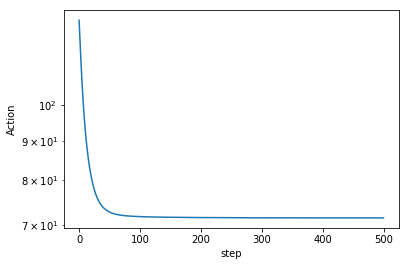

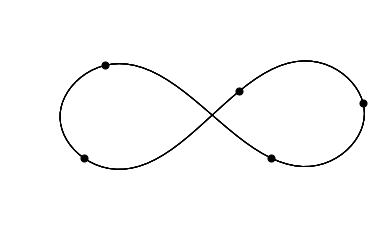

---------------------


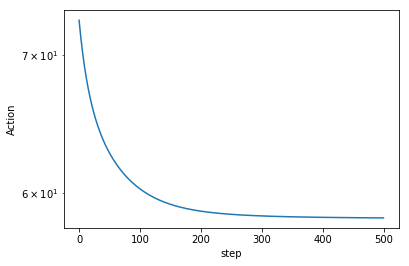

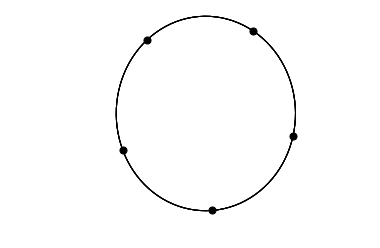

---------------------


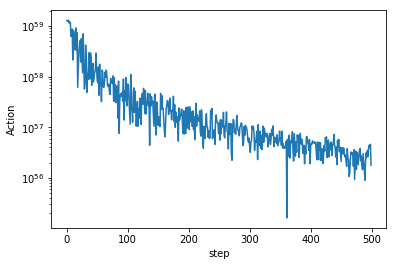

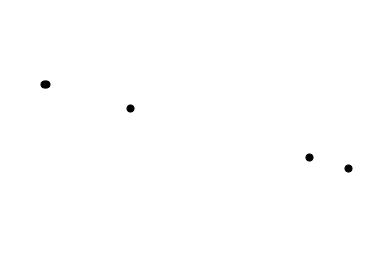

---------------------


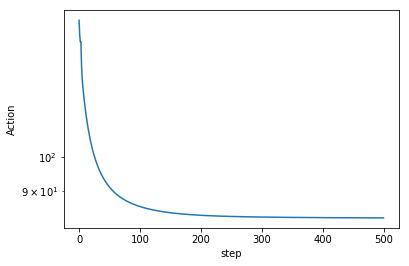

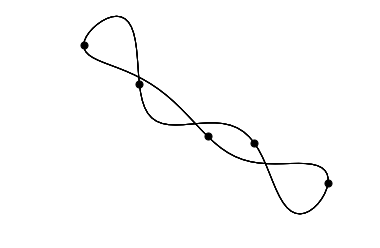

---------------------
---------------------
---------------------


In [ ]:
NUMBER_EXPERIMENTS = 5

for ii in range(NUMBER_EXPERIMENTS):

    print("---------------------")
    
    try:
    
        W_0 = initialization( PARTICLES, FOURIER_TERMS, density=0.3, decay = 1)
        W = W_0 
        S_improvement = []

        for step in range(LEARNING_STEPS):

            grad_W = grad(W)

            W -= LEARNING_RATE * grad_W

            S = action(W)
            S_improvement.append( S )
            

        plt.close()
        plt.semilogy( range(len(S_improvement)), S_improvement )
        plt.xlabel("step")
        plt.ylabel("Action")
        plt.show()

        plt.close()
        ploteo_trayectorias(W, show=True)

    except:
        pass